In [1]:
from transformers import DistilBertTokenizerFast
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset,\
                             DataLoader

from sklearn.metrics import f1_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from functions import *



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")
print('CUDA ?: ', torch.cuda.is_available())

CUDA ?:  True
CUDA ?:  True


In [2]:
data = pd.read_csv('dataset.csv')
data.head()

,text,label,link
0,В 2003-ем году под руководством малоизвестного...,0,dataset/neg/1000083-0.txt
1,"Грустно и печально. Грустно от того, что довол...",0,dataset/neg/1000083-1.txt
2,Давным-давно Кира Найтли ворвалась на экран от...,0,dataset/neg/1000125-3.txt
3,"Я, в общем, ничего против уравновешенного феми...",0,dataset/neg/1000125-4.txt
4,"Измена один из сюжетов, который всегда будет ...",0,dataset/neg/1000125-6.txt


# Скачивание модели и изменение config

In [3]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels = 3)
model.config

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

In [4]:
config = model.config
config.hidden_size = 256
config.num_attention_heads = 8
config.max_position_embedding = 256
config.max_position_embeddings = 256
config.num_hidden_layers = 4
config

BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embedding": 256,
  "max_position_embeddings": 256,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab

In [5]:
len(tokenizer.get_vocab())

119547

In [6]:
model = AutoModelForSequenceClassification.from_config(config)

In [7]:
model.config

BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embedding": 256,
  "max_position_embeddings": 256,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab

In [8]:
model.named_modules

<bound method Module.named_modules of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 256, padding_idx=0)
      (position_embeddings): Embedding(256, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (Lay

In [9]:
tokenized_text = tokenizer.batch_encode_plus(
    ["Приветствую вас господа !"],
    return_tensors = "pt",
    max_length = 256,
    truncation = True,
    pad_to_max_length = True
)

tokenized_text['input_ids']

tensor([[  101, 77527,  7508,   898, 26212, 18658,   626,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [10]:
tokenized_text = tokenizer.batch_encode_plus(
    ["Приветствую вас господа !"],
    return_tensors = "pt",
    max_length = 256,
    truncation = True,
    pad_to_max_length = True
)


input_ids = tokenized_text["input_ids"]
attention_mask = tokenized_text["attention_mask"]
print('Размерность input_ids: ', input_ids.shape)
print('Размерность attention_mask: ', attention_mask.shape)

output = model(input_ids, attention_mask)

print('Размерность скрытого состояния: ', output[0].shape)

Размерность input_ids:  torch.Size([1, 256])
Размерность attention_mask:  torch.Size([1, 256])
Размерность скрытого состояния:  torch.Size([1, 3])


# train-val split

In [11]:
train, val = train_test_split(
    data.iloc[:20000, :][['text', 'label']],
    test_size = 0.2,
    stratify = data.iloc[:20000, :]['label'],
    shuffle = True,
    random_state = 42
)

len(train), len(val)

(16000, 4000)

In [12]:
len(data)

131669

# Dataset

In [13]:
class KinopoiskDataset(Dataset):

    def __init__(self, df):

        self.data = df
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]

        self.tokenize_texts = tokenizer(
            row['text'],
            return_tensors = 'pt',
            padding = True,
            truncation = True,
            max_length = 256
            )
        input_ids = torch.zeros(256)
        attention_mask = torch.zeros(256)
        length_input_ids = len(self.tokenize_texts['input_ids'][0])
        input_ids[:length_input_ids] = self.tokenize_texts['input_ids'][0]
        attention_mask[:length_input_ids] = self.tokenize_texts['attention_mask'][0]

        return {
            'input_ids': torch.tensor(input_ids, dtype = torch.int64),
            'attention_mask': torch.tensor(attention_mask, dtype = torch.int64),
            'labels': row['label']
        }

# Dataloader

In [14]:
train_dataloader = DataLoader(
    dataset = KinopoiskDataset(train),
    batch_size = 32,
    shuffle = True,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = KinopoiskDataset(val),
    batch_size = 32,
    shuffle = False,
    drop_last = True
)

len(train_dataloader)

500

# Проверка модели

In [15]:
for batch in train_dataloader:
    break

In [16]:
input_ids = torch.tensor(batch['input_ids'], dtype = torch.int64)
attention_mask = torch.tensor(batch['attention_mask'], dtype = torch.int64)
output = model(input_ids, attention_mask)

output[0].shape

torch.Size([32, 3])

In [17]:
torch.argmax(output[0], dim = 1).detach().cpu().numpy()

array([1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 2, 1, 2, 2, 2], dtype=int64)

# model_1

Расчетное время выполнения всего цикла 11.246 минут
Epoch     1/   10 || time: 67.476 || train loss: 0.064 || val_loss: 0.060 || train f1: 0.877 || val f1: 0.866
Epoch     2/   10 || time: 66.523 || train loss: 0.063 || val_loss: 0.059 || train f1: 0.879 || val f1: 0.866
Epoch     3/   10 || time: 65.860 || train loss: 0.063 || val_loss: 0.061 || train f1: 0.879 || val f1: 0.866
Epoch     4/   10 || time: 64.119 || train loss: 0.064 || val_loss: 0.059 || train f1: 0.879 || val f1: 0.866
Epoch     5/   10 || time: 64.151 || train loss: 0.064 || val_loss: 0.059 || train f1: 0.879 || val f1: 0.866
Epoch     6/   10 || time: 64.096 || train loss: 0.076 || val_loss: 0.055 || train f1: 0.877 || val f1: 0.866
Epoch     7/   10 || time: 65.821 || train loss: 0.063 || val_loss: 0.057 || train f1: 0.879 || val f1: 0.866
Epoch     8/   10 || time: 67.958 || train loss: 0.062 || val_loss: 0.056 || train f1: 0.879 || val f1: 0.866
Epoch     9/   10 || time: 69.203 || train loss: 0.064 || val_loss: 

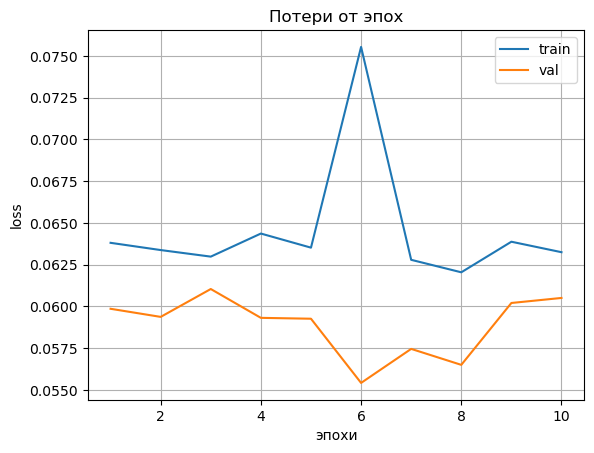

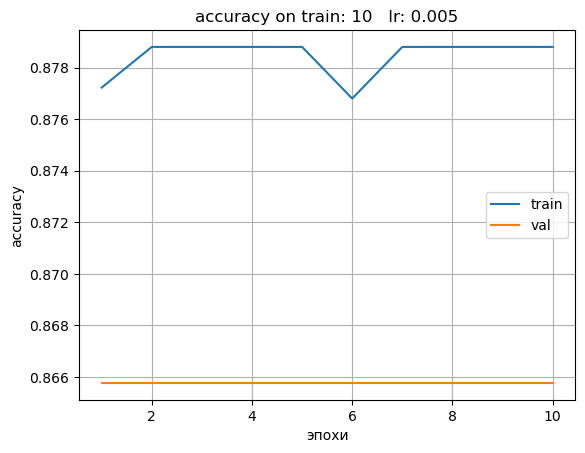

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.5, patience = 15, verbose = 1)


train_dataloader = DataLoader(
    dataset = KinopoiskDataset(train),
    batch_size = 32,
    shuffle = False,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = KinopoiskDataset(val),
    batch_size = 32,
    shuffle = False,
    drop_last = True
)


training_loop(

    name_model_folder = 'model_1',
    epoches = 10,
    model = model,
    optimizer = optimizer,
    scheduler_append = False,
    scheduler = None,
    step_on = 'val_loss',
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    stop_mode = True,
    each__X__epoch = 5,
    min_delta = 0.0001,
    patience = 5,
    verbose_epoch = 1

)